In [1]:
# Read the numerical model output, make some maps to check the conditions, crop the fields of interest in the areas
# of interest and save them in a netcdf file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import geometry as gm

In [2]:
# To plot maps.
crs = ccrs.PlateCarree()

def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [3]:
def crop_field(field,lon,lat,area):
    """
    Function to crop a 2d field over the area specified by the list
    area = [minlon,minlat,maxlon,maxlat]
    """
    valid_indices = np.argwhere((lon>area[0])&(lon<area[2])&(lat>area[1])&(lat<area[3]))
    x_min, y_min = valid_indices.min(axis=0)
    x_max, y_max = valid_indices.max(axis=0)
    return field[x_min:x_max+1, y_min:y_max+1]

In [281]:
# Set the instant and the experiment of interest.
str_instant = '2014-10-06T06:00:00'
# Valid range: from 2014-10-06_00:00:00 to 2014-10-10_00:00:00.

experiment = '3CPLD' # 'CNTRL' for d02, 'FS_CONST' and '3CPLD' for d03.

In [282]:
path2atm = '/mnt/storage_unimib/agostino/genoa2014/'+experiment+'/'
if experiment=='CNTRL':
    domain = 'd02'
    if np.double(str_instant[8:10])>8:
        atm_filename = path2atm + 'wrfout_'+domain+'_2014-10-09and10/wrfout_'+domain+'_' + str_instant[:10] + '_' + str_instant[11:]
    else:
        atm_filename = path2atm + 'wrfout_'+domain+'_'+str_instant[:10]+'/wrfout_'+domain+'_' + str_instant[:10] + '_' + str_instant[11:]
    strfile = 'ligurian_sea_full_domain_'+domain+'_'+str_instant+'.nc' # File to be saved.
    figure_name = 'ligurian_sea_full_domain_'+domain+'_'+str_instant+'_sst_and_sfc_wind.png' # Figure to be saved
else: # experiment == 'FS_CONST', '3CPLD'
    domain = 'd01'
    atm_filename = path2atm + 'wrfout_d01_' + str_instant[:10] + '_' + str_instant[11:]
    strfile = 'ligurian_sea_full_domain_d03_'+experiment +'_'+str_instant+'.nc' # File to be saved
    figure_name = 'ligurian_sea_full_domain_d03_'+experiment+'_'+str_instant+'_sst_and_sfc_wind.png' # Figure to be saved

print(atm_filename)

/mnt/storage_unimib/agostino/genoa2014/3CPLD/wrfout_d01_2014-10-06_06:00:00


In [283]:
# Read the file
ds_atm = xr.open_dataset(atm_filename)

# Select the atmospheric variables of interest.
lon_atm = ds_atm['XLONG'][0].values
lat_atm = ds_atm['XLAT'][0].values
lakemask = ds_atm['LAKEMASK'][0].values
landmask = ds_atm['LANDMASK'][0].values
sst_atm = ds_atm['SST'][0].values
u10_mod = ds_atm['U10'][0].values
v10_mod = ds_atm['V10'][0].values
cosalpha = ds_atm['COSALPHA'][0].values
sinalpha = ds_atm['SINALPHA'][0].values

seamask = 1 - lakemask - landmask
seamask_nan = np.where(seamask==1,seamask,np.nan)
u10 = u10_mod*cosalpha - v10_mod*sinalpha
v10 = u10_mod*sinalpha + v10_mod*cosalpha

<ipython-input-284-4995311325f3>:4: RuntimeWarning: divide by zero encountered in true_divide
  pc = plt.pcolormesh(lon_atm,lat_atm,(sst_atm-273.15)/seamask,vmin=19.5,vmax=27)


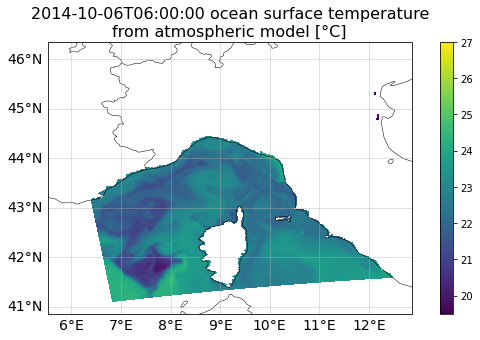

In [284]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon_atm,lat_atm,(sst_atm-273.15)/seamask,vmin=19.5,vmax=27)
step = 15

plt.title(str_instant + ' ocean surface temperature\nfrom atmospheric model [°C]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)

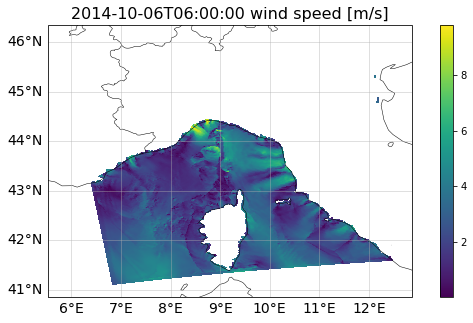

In [285]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon_atm,lat_atm,np.sqrt(u10**2+v10**2)*seamask_nan)

plt.title(str_instant + ' wind speed [m/s]', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)

In [286]:
# Save the netcdf file.
# Create a dataset.
ds = xr.Dataset(
    data_vars = dict(
        lon=(["x","y"],lon_atm),    
        lat=(["x","y"],lat_atm),    
        sst=(["x","y"],sst_atm,dict(units='K')),    
        u10=(["x","y"],u10,dict(units='m/s')),    
        v10=(["x","y"],v10,dict(units='m/s')),
        seamask=(["x","y"],seamask)
    ),
    attrs=dict(
        ref_time = str_instant,
        domain = domain
    )
)

# Save the netcdf.
#strfile = 'ligurian_sea_full_domain_'+domain+'_'+str_instant+'.nc'
ds.to_netcdf(strfile)

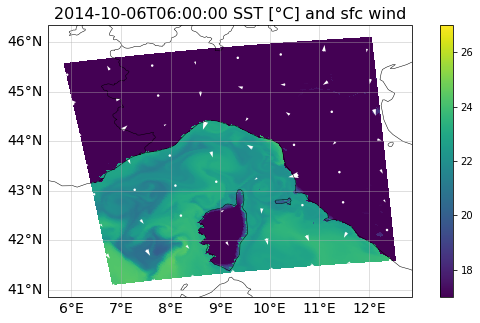

In [287]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
plot_background(ax)
pc = plt.pcolormesh(lon_atm,lat_atm,sst_atm-273.15,vmin=17,vmax=27)
step = 50
qv = plt.quiver(lon_atm[::step,::step],lat_atm[::step,::step],u10[::step,::step],v10[::step,::step],
                color='w',scale=200)
#ct = plt.contour(lon_c,lat_c,np.sqrt(u10_c**2+v10_c**2),colors='r')
plt.title(str_instant + ' SST [°C] and sfc wind', fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.colorbar(pc)
#figure_name = 'ligurian_sea_full_domain_'+domain+'_'+str_instant+'_sst_and_sfc_wind.png'
plt.savefig(figure_name,bbox_inches='tight') 